In [ ]:
# pifrom google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


In [3]:
# Define the directory containing the dataset
dataset_dir = "Eye"
image_height = 256
image_width = 256
num_channels = 3  # Assuming RGB

In [4]:

# Function to load and preprocess the dataset
def load_dataset(dataset_dir, image_height, image_width, num_channels):
    X = []
    y = []
    classes = os.listdir(dataset_dir)
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(dataset_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image = load_img(image_path, target_size=(image_height, image_width))
            image = img_to_array(image)
            X.append(image)
            y.append(i)  # Assigning class labels (0, 1, 2, ...) based on class index
    X = np.array(X)
    y = np.array(y)
    return X, y

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def apply_median_clahe(image):
    # Apply median filter to each channel separately
    median_image = np.zeros_like(image)
    for i in range(image.shape[2]):  # Iterate over channels
        median_image[:, :, i] = cv2.medianBlur(image[:, :, i], 3)

    # Convert channels to 8-bit unsigned integers
    median_image = median_image.astype(np.uint8)

    # Apply CLAHE to each channel separately
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_images = []
    for i in range(image.shape[2]):  # Iterate over channels
        clahe_images.append(clahe.apply(median_image[:, :, i]))

    # Merge the CLAHE enhanced channels
    clahe_image = np.stack(clahe_images, axis=-1)

    return median_image, clahe_image
# Function to preprocess the dataset with augmentation
def preprocess_dataset_with_augmentation(X):
    preprocessed_X = []
    for image in X:
        # Apply median filter and CLAHE enhancement
        median_image, clahe_image = apply_median_clahe(image)

        # Resize image to desired dimensions
        resized_image = cv2.resize(clahe_image, (image_height, image_width))

        # Normalize pixel values to the range [0, 1]
        normalized_image = resized_image.astype('float32') / 255.0
        preprocessed_X.append(normalized_image)

    augmented_images = []
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    for batch in datagen.flow(np.array(preprocessed_X), batch_size=len(X), shuffle=False):
        augmented_images.extend(batch)
        break

    return np.array(augmented_images)

# Load the dataset
X_train, y_train = load_dataset(dataset_dir, image_height, image_width, num_channels)

# Apply data augmentation to the training set
X_train_preprocessed_augmented = preprocess_dataset_with_augmentation(X_train)



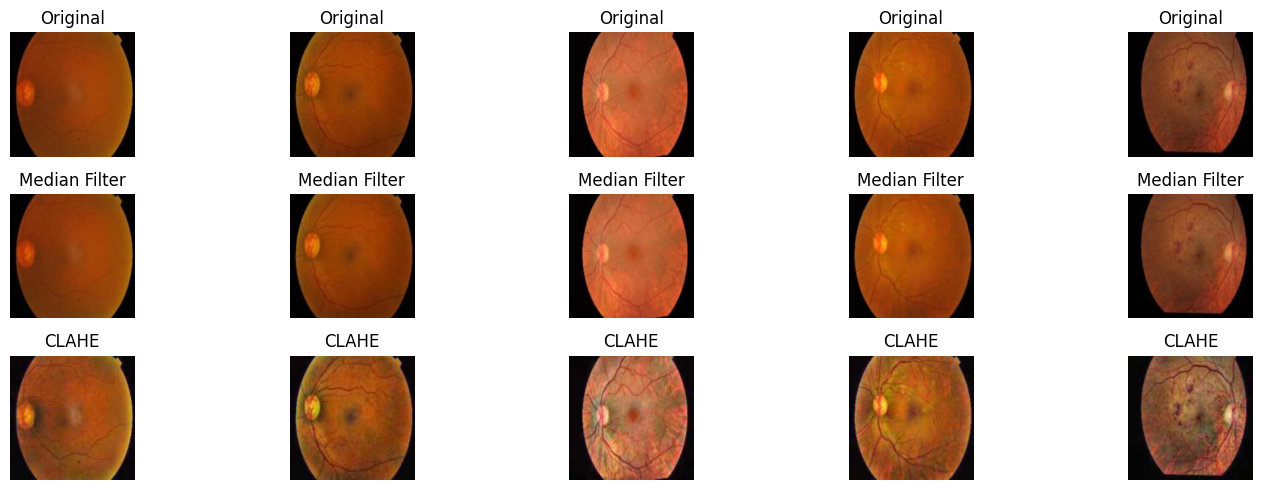

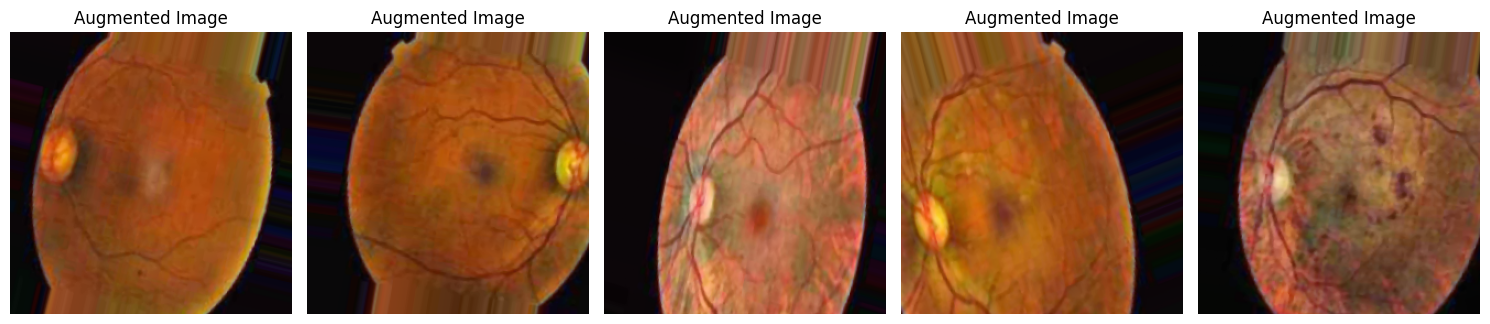

In [6]:
# Plot original, median filter, and CLAHE-enhanced images
plt.figure(figsize=(15, 5))
num_images_to_plot = 5
for i in range(num_images_to_plot):
    original_image = X_train[i]
    median_image, clahe_image = apply_median_clahe(original_image)

    plt.subplot(3, num_images_to_plot, i + 1)
    plt.imshow(original_image.astype('uint8'))
    plt.title('Original')
    plt.axis('off')

    plt.subplot(3, num_images_to_plot, i + 1 + num_images_to_plot)
    plt.imshow(median_image.astype('uint8'))
    plt.title('Median Filter')
    plt.axis('off')

    plt.subplot(3, num_images_to_plot, i + 1 + 2 * num_images_to_plot)
    plt.imshow(clahe_image.astype('uint8'))
    plt.title('CLAHE')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Plot the augmented images
plt.figure(figsize=(15, 5))
for i in range(num_images_to_plot):
    plt.subplot(1, num_images_to_plot, i + 1)
    plt.imshow(X_train_preprocessed_augmented[i])
    plt.title('Augmented Image')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Load the dataset
X, y = load_dataset(dataset_dir, image_height, image_width, num_channels)

In [8]:
# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [9]:
# Preprocess the training, validation, and test sets
X_train_preprocessed = preprocess_dataset_with_augmentation(X_train)
X_val_preprocessed = preprocess_dataset_with_augmentation(X_val)
X_test_preprocessed = preprocess_dataset_with_augmentation(X_test)

In [10]:
# Define the CNN model architecture
def create_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(5, activation='softmax')  # 5 classes for severity levels
    ])
    return model

In [11]:
# Create and compile the model
input_shape = (image_height, image_width, num_channels)
model = create_model(input_shape)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [12]:
# Train the model
history = model.fit(X_train_preprocessed, y_train, epochs=10, batch_size=32, validation_data=(X_val_preprocessed, y_val))


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:GPU:0 to /job:localhost/replica:0/task:0/device:CPU:0 in order to run TensorDataset: Dst tensor is not initialized. [Op:TensorDataset]

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test)
print("Test Accuracy:", test_accuracy)


9/9 [==============================] - 0s 21ms/step - loss: 1.3381 - accuracy: 0.7183
Test Accuracy: 0.7183098793029785


In [ ]:
# Make predictions
predictions = model.predict(X_test_preprocessed)

9/9 [==============================] - 0s 20ms/step


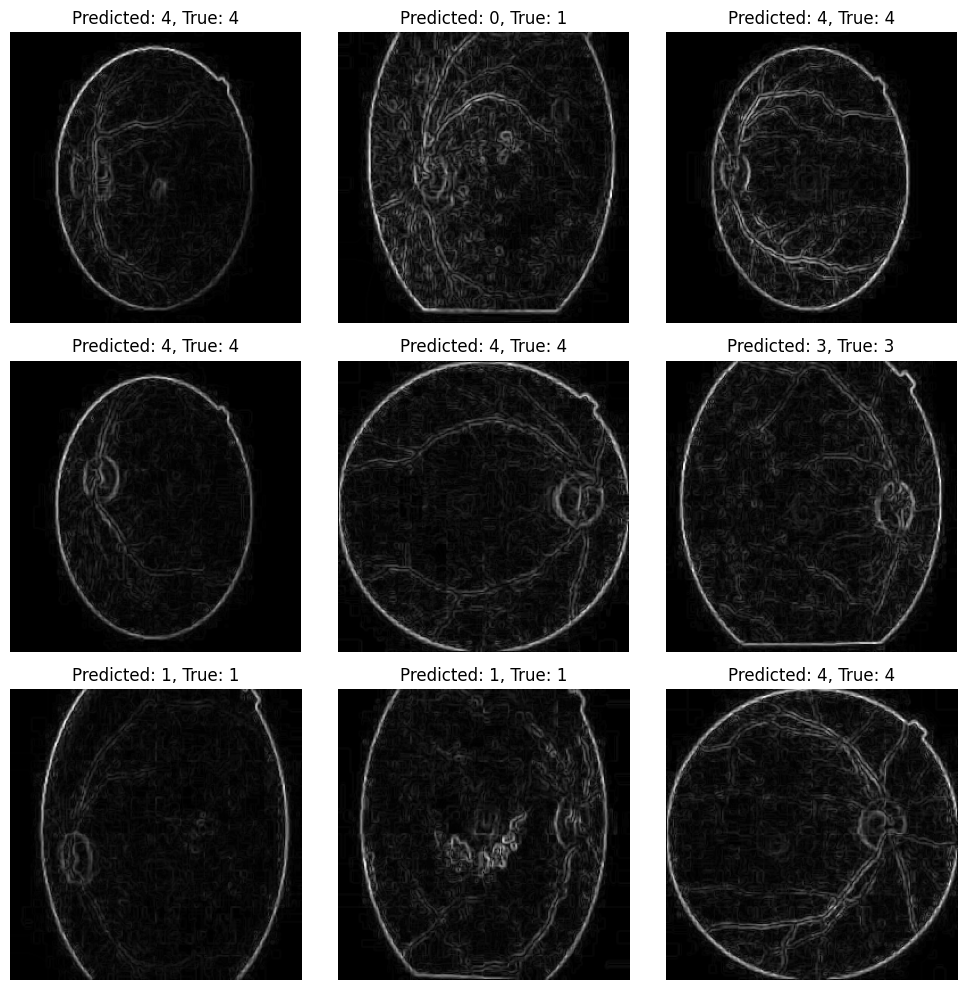

In [ ]:
import matplotlib.pyplot as plt
# Plot prediction images with labels
plt.figure(figsize=(10, 10))
for i in range(9):  # Adjust the number of images to plot
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test_preprocessed[i], cmap='gray')
    predicted_label = np.argmax(predictions[i])  # Get the index of the highest probability
    true_label = y_test[i]
    plt.title(f"Predicted: {predicted_label}, True: {true_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()
